<a href="https://colab.research.google.com/github/phuvo05/AI-VIETNAM-ASSIGNMENT/blob/main/sentiment_analysis_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# https://drive.google.com/file/d/1uYXI4O3oWBA6QC8ZJ-r6yaTTfkdAnl_Q/view

# Cài gdown
!pip install unidecode
!pip install -q gdown

# Tải file từ link Drive
!gdown --id 1uYXI4O3oWBA6QC8ZJ-r6yaTTfkdAnl_Q # ← thay bằng ID thật

# Giải nén
!unzip -q dataset.zip


/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1uYXI4O3oWBA6QC8ZJ-r6yaTTfkdAnl_Q
To: /content/dataset.zip
100% 230k/230k [00:00<00:00, 97.5MB/s]


In [3]:
# !pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 4.4 MB/s eta 0:00:00


## **1. Import libraries**

In [5]:
import torch
import torch.nn as nn

seed = 1
torch.manual_seed(seed)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import unidecode

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## **2. Read dataset**

In [24]:
dataset_path = '/content/dataset/all-data.csv'
headers = ['sentiment', 'content']
df = pd.read_csv(dataset_path, names=headers, encoding='ISO-8859-1')
df.head()

,sentiment,content
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


## **3. Text normalize**

In [25]:
classes = {
    class_name: idx\
        for idx, class_name in enumerate(df['sentiment'].unique().tolist())
}

df['sentiment'] = df['sentiment'].map(classes) # normalize
df.head()


,sentiment,content
0,0,"According to Gran , the company has no plans t..."
1,0,Technopolis plans to develop in stages an area...
2,1,The international electronic industry company ...
3,2,With the new production plant the company woul...
4,2,According to the company 's updated strategy f...


In [26]:
english_stop_words = stopwords.words('english')
stemmer = PorterStemmer()

def text_normalize(text):
    text = text.lower()
    text = unidecode.unidecode(text)
    text = text.strip()
    text = re.sub(r'[^a-z]', ' ', text)
    text = ' '.join([word for word in text.split(' ') if word not in english_stop_words])
    text = ' '.join([stemmer.stem(word) for word in text.split(' ')])
    return text


df['content'] = df['content'].apply(text_normalize)
# df['content'] = df['content'].apply(lambda x: text_normalize(x))
df.head()


,sentiment,content
0,0,accord gran compani plan move product russia...
1,0,technopoli plan develop stage area less ...
2,1,intern electron industri compani elcoteq laid ...
3,2,new product plant compani would increas capac ...
4,2,accord compani updat strategi year ...


## **4. Text Transformation**

In [28]:
vocab = []

for sentence in df['content'].tolist():
    tokens = sentence.split()
    for token in tokens:
        if token not in vocab:
            vocab.append(token)

vocab.append('UNK')
vocab.append('PAD')

word_to_idx = {word:idx for idx,word in enumerate(vocab)}
idx_to_word = {idx:word for idx,word in enumerate(vocab)}

vocab_size = len(vocab)
print(f'Vocabulary size: {vocab_size}')

Vocabulary size: 6705


In [31]:
def transform(text, word_to_idx, max_seq_len):
    tokens = []
    for w in text.split():
        try:
            w_ids = word_to_idx[w]
        except:
            w_ids = word_to_idx['UNK']
        tokens.append(w_ids)

    if len(tokens) < max_seq_len:
        tokens += [word_to_idx['UNK']] * (max_seq_len - len(tokens))
    elif len(tokens) > max_seq_len:
        tokens = tokens[:max_seq_len]
    return tokens

## **5. Train, val, test split**

In [32]:
val_size = 0.2
test_size = 0.125
is_shuffle = True
texts = df['content'].tolist()
labels = df['sentiment'].tolist()

X_train, X_val, y_train, y_val = train_test_split(
    texts, labels,
    test_size=val_size,
    shuffle=is_shuffle
)
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    shuffle=is_shuffle
)

## **6. Create pytorch dataset and data preprocessing function**

In [33]:
class FinancialNews(Dataset):
    def __init__(self,X,y,word_to_idx,max_seq_len, transform = None):
        self.texts = X
        self.labels = y
        self.word_to_idx = word_to_idx
        self.max_seq_len = max_seq_len
        self.transform = transform

    def __len__ (self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        if self.transform:
            text = self.transform(text, self.word_to_idx, self.max_seq_len)
        text = torch.tensor(text)

        return text, label


## **7. Create dataloader**

In [34]:
max_seq_len = 32

train_dataset = FinancialNews(X_train, y_train, word_to_idx, max_seq_len, transform)
val_dataset = FinancialNews(X_val, y_val, word_to_idx, max_seq_len, transform)
test_dataset = FinancialNews(X_test, y_test, word_to_idx, max_seq_len, transform)

train_batch_size = 128
test_batch_size = 8

train_loader = DataLoader(
        train_dataset,
        batch_size=train_batch_size,
        shuffle=True
)
val_loader = DataLoader(
        val_dataset,
        batch_size=test_batch_size,
        shuffle=False
)
test_loader = DataLoader(
        test_dataset,
        batch_size=test_batch_size,
        shuffle=False
)

## **8. Create model**

In [35]:
class SentimentClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, n_layers, n_classes, dropout_prob):
        super(SentimentClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, n_layers, batch_first=True)
        self.norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(hidden_size, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, n_classes)

    def forward(self, x):
        x = self.embedding(x)
        x, hn = self.rnn(x)
        x = x[:,-1,: ]
        x = self.norm(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x


## **9. Training**

In [36]:
n_classes = len(list(classes.keys()))
embedding_dim = 64
hidden_size = 64
n_layers = 2
dropout_prob = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = SentimentClassifier(
    vocab_size,
    embedding_dim,
    hidden_size,
    n_layers,
    n_classes,
    dropout_prob
).to(device)



In [37]:
lr =  1e-4
epochs = 50

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [39]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    epochs,
    device
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []
        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())
        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}')
    return train_losses, val_losses


In [38]:
def evaluate(model, val_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss = sum(losses) / len(losses)
    acc = 100 * correct / total
    return loss, acc

In [40]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    epochs,
    device
)

EPOCH 1:	Train loss: 0.9942	Val loss: 0.9470
EPOCH 2:	Train loss: 0.9274	Val loss: 0.9501
EPOCH 3:	Train loss: 0.9275	Val loss: 0.9497
EPOCH 4:	Train loss: 0.9313	Val loss: 0.9486
EPOCH 5:	Train loss: 0.9268	Val loss: 0.9484
EPOCH 6:	Train loss: 0.9278	Val loss: 0.9475
EPOCH 7:	Train loss: 0.9266	Val loss: 0.9486
EPOCH 8:	Train loss: 0.9285	Val loss: 0.9490
EPOCH 9:	Train loss: 0.9246	Val loss: 0.9477
EPOCH 10:	Train loss: 0.9256	Val loss: 0.9484
EPOCH 11:	Train loss: 0.9243	Val loss: 0.9476
EPOCH 12:	Train loss: 0.9277	Val loss: 0.9482
EPOCH 13:	Train loss: 0.9291	Val loss: 0.9474
EPOCH 14:	Train loss: 0.9286	Val loss: 0.9480
EPOCH 15:	Train loss: 0.9265	Val loss: 0.9475
EPOCH 16:	Train loss: 0.9276	Val loss: 0.9473
EPOCH 17:	Train loss: 0.9248	Val loss: 0.9474
EPOCH 18:	Train loss: 0.9254	Val loss: 0.9479
EPOCH 19:	Train loss: 0.9233	Val loss: 0.9472
EPOCH 20:	Train loss: 0.9236	Val loss: 0.9477
EPOCH 21:	Train loss: 0.9283	Val loss: 0.9472
EPOCH 22:	Train loss: 0.9294	Val loss: 0.94

## **10. Evaluation**

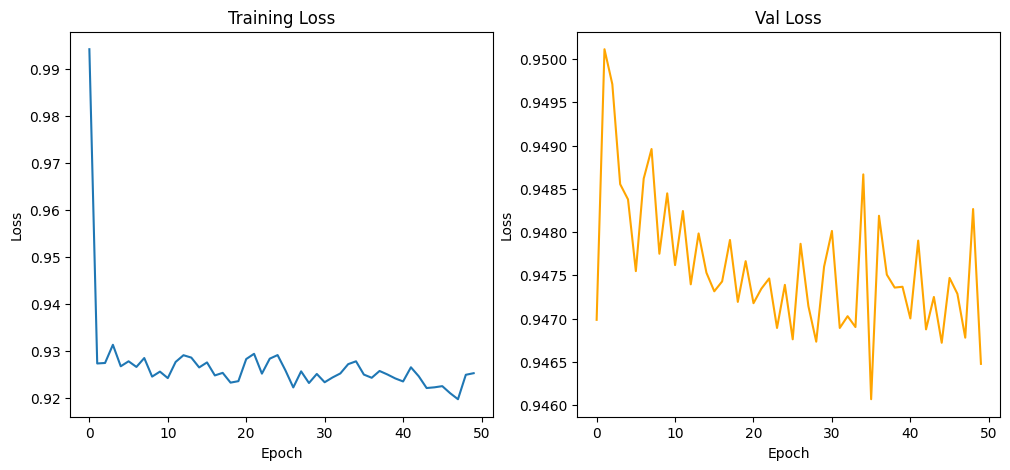

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_losses, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

In [42]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device
)

test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('evaluation on val/test dataset')
print('Val accuracy: ',val_acc)
print('Test accuracy: ', test_acc)

evaluation on val/test dataset
Val accuracy:  58.76288659793814
Test accuracy:  59.175257731958766
